# Online MMD（Alibi Detect）でTEP時系列を「窓→特徴量→分布変化」として検知する

このノートは、時系列（`[時刻, センサ数]`）を **窓ごとに区切って特徴量へ変換**し、その特徴量の分布変化を **Alibi Detect の `MMDDriftOnline`** で検知します。

## パイプライン
生データ（多変量時系列）  
→ 窓分割（`WIN`, `STEP`）  
→ 窓特徴量（窓内の基本統計 + FFT振幅の上位成分）  
→ 標準化（参照でfit）  
→ `MMDDriftOnline`（オンライン監視）

## 重要（初期化エラーの条件）
`MMDDriftOnline` は初期化時に参照データから閾値を校正するため、参照の「窓数」が不足するとエラーになります。  
おおむね次が必要です（`W=window_size`, `n_ref_w=参照の窓数`）：

\[
n_{ref\_w} - W + 1 \ge \lceil ert \rceil
\]

不足する場合は、参照データを長くする／`window_size` を小さくする／`ert` を小さくしてください。


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from alibi_detect.cd import MMDDriftOnline

import alibi_detect
print("alibi-detect:", alibi_detect.__version__)


alibi-detect: 0.13.0


In [48]:
# ============================================================
# 設定（ここだけ変えればOK）
# ============================================================
NORMAL_CSV  = r"..\sampleData\csv_TEPdata\tuning-data.csv"
ANOMALY_CSV = r"..\sampleData\csv_TEPdata\idv_str14_data.csv"  # 例: idv_str1_data.csv など

TIME_COL  = None   # 時刻列があるなら列名（なければ None）
LABEL_COL = None   # ラベル列があるなら列名（なければ None）

FEATURE_COLS = None          # Noneなら数値列から自動
SENSOR_COLS  = None          # Noneなら FEATURE_COLS を使う（例: ["s1","s2"] に固定も可）

# --- 窓→特徴量 ---
WIN  = 100     # 窓長（サンプル数）
STEP = 5      # 窓のずらし幅
FFT_K = 30     # FFT特徴の本数（センサごと）
USE_LOG_AMP = True  # FFT振幅に log1p をかける

# --- Online MMD ---
window_size  = 10
ert          = 100.0
n_bootstraps = 5000
backend      = "tensorflow"  # "pytorch" でも可

# ログ保存（必要なら）
SAVE_LOG_CSV = False
LOG_CSV_PATH = "mmdonline_log.csv"


In [49]:
# ============================================================
# 0) 入力
# ============================================================
df_normal = pd.read_csv(NORMAL_CSV)
df_anom   = pd.read_csv(ANOMALY_CSV)

print("df_normal:", df_normal.shape)
print("df_anom  :", df_anom.shape)

# ============================================================
# 1) 特徴量列
# ============================================================
if FEATURE_COLS is None:
    cols = df_normal.select_dtypes(include=[np.number]).columns.tolist()
    if TIME_COL is not None and TIME_COL in cols:
        cols.remove(TIME_COL)
    if LABEL_COL is not None and LABEL_COL in cols:
        cols.remove(LABEL_COL)
    FEATURE_COLS = cols

if SENSOR_COLS is None:
    SENSOR_COLS = FEATURE_COLS

missing = [c for c in SENSOR_COLS if c not in df_anom.columns]
if missing:
    raise ValueError(f"ANOMALY_CSV に列がありません: {missing}")

X_ref = df_normal[SENSOR_COLS].to_numpy(np.float32)  # (T_ref, D)
X_test = df_anom[SENSOR_COLS].to_numpy(np.float32)   # (T_test, D)

print("X_ref :", X_ref.shape, "X_test:", X_test.shape)


df_normal: (960, 52)
df_anom  : (960, 52)
X_ref : (960, 52) X_test: (960, 52)


In [50]:
# ============================================================
# 2) 窓→特徴量（統計 + FFT）
# ============================================================
def window_features_fft(X: np.ndarray, win: int, step: int, fft_k: int = 20, use_log: bool = True):
    """
    X: shape (T, D)  T=時系列長, D=センサ数

    戻り値:
      F: shape (Nw, D*(stats_dim + fft_k))  窓ごとの特徴量
      t_idx: shape (Nw,)  窓の代表時刻インデックス（中央）

    特徴:
      - 統計: mean, std, min, max, rms, diff_rms（センサごと）
      - FFT: rFFT振幅のうち DC(0番)を除いた低周波側から fft_k 個（センサごと）
    """
    X = np.asarray(X, dtype=np.float32)
    T, D = X.shape
    if T < win:
        raise ValueError(f"T={T} が win={win} より短いです。win を小さくするかデータを長くしてください。")

    n_w = 1 + (T - win) // step
    stats_dim = 6  # mean,std,min,max,rms,diff_rms

    F = np.zeros((n_w, D * (stats_dim + fft_k)), dtype=np.float32)
    t_idx = np.zeros(n_w, dtype=int)

    for i in range(n_w):
        s = i * step
        e = s + win
        w = X[s:e, :]  # (win, D)
        t_idx[i] = s + win // 2

        # --- 統計（センサごと） ---
        mean = w.mean(axis=0)
        std  = w.std(axis=0, ddof=0)
        wmin = w.min(axis=0)
        wmax = w.max(axis=0)
        rms  = np.sqrt((w ** 2).mean(axis=0))
        dw   = np.diff(w, axis=0)
        diff_rms = np.sqrt((dw ** 2).mean(axis=0))

        stats = np.stack([mean, std, wmin, wmax, rms, diff_rms], axis=1).reshape(-1)  # (D*6,)

        # --- FFT（センサごと） ---
        spec = np.fft.rfft(w, axis=0)
        amp = np.abs(spec).astype(np.float32)

        amp_no_dc = amp[1:, :]  # DC除外
        k = min(fft_k, amp_no_dc.shape[0])
        fft_feat = amp_no_dc[:k, :].T.reshape(-1)  # (D*k,)

        if k < fft_k:
            pad = np.zeros((D * (fft_k - k),), dtype=np.float32)
            fft_feat = np.concatenate([fft_feat, pad], axis=0)

        if use_log:
            fft_feat = np.log1p(fft_feat)

        F[i, :] = np.concatenate([stats, fft_feat], axis=0)

    return F, t_idx


In [51]:
# ============================================================
# 3) 窓特徴量を作成 → 標準化（参照でfit）
# ============================================================
X_ref_feat, t_ref = window_features_fft(X_ref,  win=WIN, step=STEP, fft_k=FFT_K, use_log=USE_LOG_AMP)
X_test_feat, t_test = window_features_fft(X_test, win=WIN, step=STEP, fft_k=FFT_K, use_log=USE_LOG_AMP)

scaler = StandardScaler().fit(X_ref_feat)
X_ref_feat_std = scaler.transform(X_ref_feat).astype(np.float32)
X_test_feat_std = scaler.transform(X_test_feat).astype(np.float32)

print("ref_feat_std :", X_ref_feat_std.shape)
print("test_feat_std:", X_test_feat_std.shape)

# 参照の窓数が足りるか（初期化エラー対策）
n_ref_w = X_ref_feat_std.shape[0]
W = window_size
N_eff = n_ref_w - W + 1
need = int(np.ceil(ert))
print("n_ref_windows =", n_ref_w, "window_size =", W, "N_eff =", N_eff, "need(ceil(ert)) =", need)

if N_eff < need:
    raise ValueError(
        f"参照の窓数が不足: n_ref_windows={n_ref_w}, window_size={W} なので N_eff={N_eff}。"
        f"少なくとも ceil(ert)={need} 以上必要。"
        f"（対策：参照データを長くする / window_sizeを小さくする / ertを小さくする）"
    )


ref_feat_std : (173, 1872)
test_feat_std: (173, 1872)
n_ref_windows = 173 window_size = 10 N_eff = 164 need(ceil(ert)) = 100


In [52]:
# ============================================================
# 4) Online MMD を初期化
# ============================================================
cd = MMDDriftOnline(
    x_ref=X_ref_feat_std,
    ert=ert,
    window_size=window_size,
    backend=backend,
    n_bootstraps=n_bootstraps,
    verbose=True
)


Generating permutations of kernel matrix..


Computing thresholds: 100%|██████████| 10/10 [01:27<00:00,  8.80s/it]


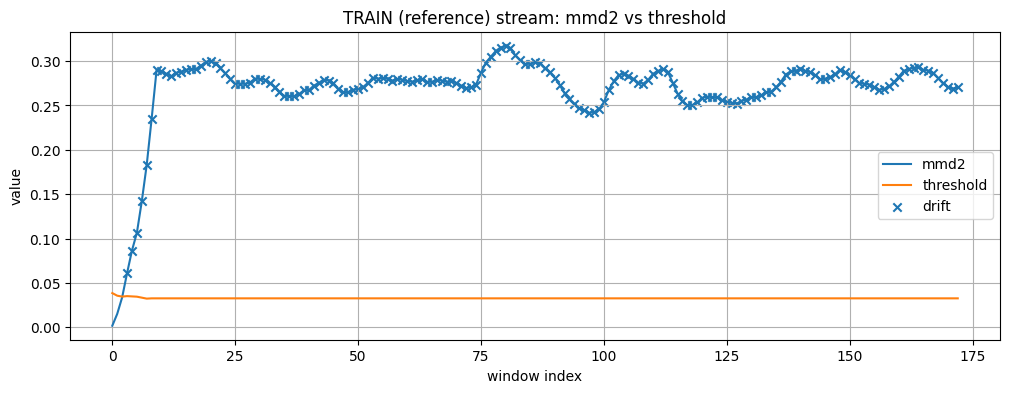

TRAIN drift count: 170


,win_i,t_center_idx,mmd2,threshold,is_drift
0,0,50,0.001849,0.038609,0
1,1,55,0.015180,0.035682,0
2,2,60,0.033737,0.034665,0
3,3,65,0.060912,0.035196,1
4,4,70,0.086584,0.034858,1


In [53]:
# ============================================================
# 4.5) 参照（学習）を逐次投入してログ化・可視化
# ============================================================
n_tr = X_ref_feat_std.shape[0]
mmd2_tr = np.full(n_tr, np.nan, float)
thr_tr  = np.full(n_tr, np.nan, float)
dr_tr   = np.zeros(n_tr, int)

for i in range(n_tr):
    out = cd.predict(X_ref_feat_std[i], return_test_stat=True)
    d = out["data"]
    mmd2_tr[i] = float(d.get("test_stat", np.nan))
    thr_tr[i]  = float(d.get("threshold", np.nan))
    dr_tr[i]   = int(d.get("is_drift", 0))

df_log_train = pd.DataFrame({
    "win_i": np.arange(n_tr),
    "t_center_idx": t_ref,          # window_features_fft で返した参照側の中心インデックス
    "mmd2": mmd2_tr,
    "threshold": thr_tr,
    "is_drift": dr_tr
})

# 可視化（参照データ上でのスコアと閾値）
FIGSIZE = (12, 4)

fig, ax = plt.subplots(figsize=FIGSIZE)
ax.plot(df_log_train["win_i"], df_log_train["mmd2"], label="mmd2")
ax.plot(df_log_train["win_i"], df_log_train["threshold"], label="threshold")

# drift点に印を付ける（色指定なし）
idx = df_log_train.index[df_log_train["is_drift"].to_numpy() == 1].to_numpy()
ax.scatter(df_log_train.loc[idx, "win_i"], df_log_train.loc[idx, "mmd2"], marker="x", label="drift")

ax.set_title("TRAIN (reference) stream: mmd2 vs threshold")
ax.set_xlabel("window index")
ax.set_ylabel("value")
ax.grid(True)
ax.legend()
plt.show()

print("TRAIN drift count:", int(df_log_train["is_drift"].sum()))
df_log_train.head()


In [54]:
# ============================================================
# 5) テストを逐次投入してログ化
# ============================================================
# 参照を流したので内部状態をリセットして、テストを“新しいストリーム”として開始する
cd.reset_state()


n_te = X_test_feat_std.shape[0]
mmd2 = np.full(n_te, np.nan, float)
thr  = np.full(n_te, np.nan, float)
dr   = np.zeros(n_te, int)

for i in range(n_te):
    out = cd.predict(X_test_feat_std[i], return_test_stat=True)
    d = out["data"]
    mmd2[i] = float(d.get("test_stat", np.nan))
    thr[i]  = float(d.get("threshold", np.nan))
    dr[i]   = int(d.get("is_drift", 0))

df_log = pd.DataFrame({
    "win_i": np.arange(n_te),
    "t_center_idx": t_test,
    "mmd2": mmd2,
    "threshold": thr,
    "is_drift": dr
})
df_log.head()


,win_i,t_center_idx,mmd2,threshold,is_drift
0,0,50,0.005356,0.038609,0
1,1,55,0.023602,0.035682,0
2,2,60,0.049046,0.034665,1
3,3,65,0.080075,0.035196,1
4,4,70,0.112968,0.034858,1


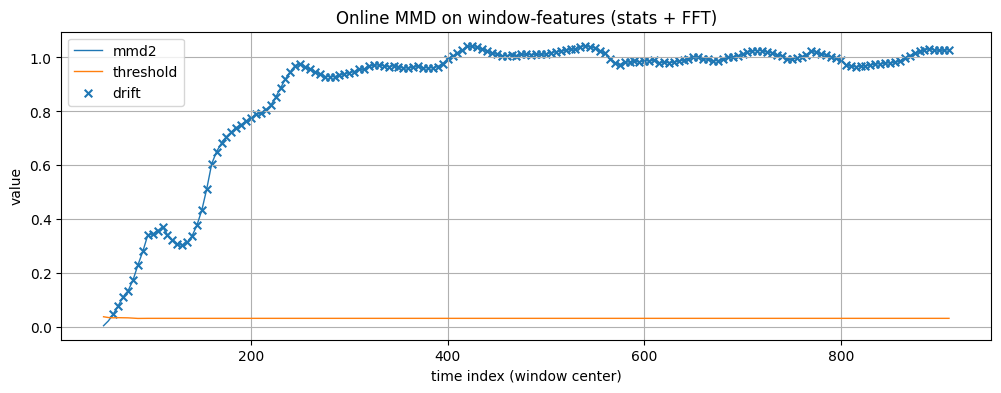

In [55]:
# ============================================================
# 6) 可視化（MMD^2 と threshold）
# ============================================================
x = df_log["t_center_idx"].to_numpy()

plt.figure(figsize=(12,4))
plt.plot(x, df_log["mmd2"].to_numpy(), linewidth=1.0, label="mmd2")
plt.plot(x, df_log["threshold"].to_numpy(), linewidth=1.0, label="threshold")

# drift点（色指定はしない。マーカーだけ変える）
mask = df_log["is_drift"].to_numpy().astype(bool)
if mask.any():
    plt.scatter(x[mask], df_log["mmd2"].to_numpy()[mask], marker="x", s=30, label="drift")

plt.grid(True)
plt.legend()
plt.title("Online MMD on window-features (stats + FFT)")
plt.xlabel("time index (window center)")
plt.ylabel("value")
plt.show()


In [56]:
# ============================================================
# 7) driftの要約
# ============================================================
drift_rows = df_log[df_log["is_drift"] == 1]
print("n_drift_windows:", drift_rows.shape[0])
if drift_rows.shape[0] > 0:
    print("first drift at t_center_idx:", int(drift_rows.iloc[0]["t_center_idx"]))
    display(drift_rows.head(10))

if SAVE_LOG_CSV:
    df_log.to_csv(LOG_CSV_PATH, index=False)
    print("saved:", LOG_CSV_PATH)


n_drift_windows: 171
first drift at t_center_idx: 60


,win_i,t_center_idx,mmd2,threshold,is_drift
2,2,60,0.049046,0.034665,1
3,3,65,0.080075,0.035196,1
4,4,70,0.112968,0.034858,1
5,5,75,0.135167,0.034572,1
6,6,80,0.174916,0.033476,1
7,7,85,0.231079,0.032379,1
8,8,90,0.281458,0.032696,1
9,9,95,0.341752,0.032696,1
10,10,100,0.345269,0.032696,1
11,11,105,0.357296,0.032696,1
